In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
sns.set(style="darkgrid", color_codes=True)

# load data
df = pd.read_csv('./data/final_amazon_beauty.csv')

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create dataframe

In [5]:
data = df[['rating', 'product_id', 'title', 'reviewer_id']]
data.head(5)

,rating,product_id,title,reviewer_id
0,5,0061073717,Workout Headphones by Arena Essentials,A2XMFX1BR0IJFJ
1,5,0061073717,Workout Headphones by Arena Essentials,ATKPYXA8XFKGJ
2,1,0143026860,Black Diamond,A1V6B6TNIC10QE
3,4,0143026860,Black Diamond,A2F5GHSXFQ0W6J
4,4,0143026860,Black Diamond,A1572GUYS7DGSR


In [48]:
product_ratings = data.groupby('product_id').rating.apply(list).reset_index()
product_ratings['number_of_ratings'] = product_ratings['rating'].str.len() # len(product_ratings.rating)
product_ratings.head()

,product_id,rating,number_of_ratings
0,0061073717,"[5, 5]",2
1,0143026860,"[1, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 3, 5, 5, 3, ...",17
2,014789302X,"[1, 5, 1, 2, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",20
3,0571348351,"[5, 5, 5]",3
4,0692508988,[5],1


## Categorizing reviews into positive and negative

In [37]:
# pos_neg_review_scores = list(map(
#         lambda rating: [rating >= 4], data.rating.tolist()
# ))
# pos_neg_review_scores

pos_neg_review_scores = list(
    map(
        lambda ratings: [r >= 4 for r in ratings], product_ratings.rating.tolist()
    )
)

## Wilson Confidence Interval

In [38]:
import scipy.stats as st
import numpy as np

def wilson_confidence_interval(X, c):
    n = len(X)
    
    z_score = st.norm.ppf(1 - ((1 - c) / 2))
    p_hat = np.array(X).astype(int).sum() / n
    
    correction_1 = z_score * z_score / (2*n)
    correction_2 = z_score * np.sqrt((p_hat*(1-p_hat) + z_score * z_score/(4 * n))/n) / (1 + z_score * z_score /n)
    additive_part = correction_1 + correction_2

    return (p_hat - additive_part, p_hat + additive_part)

In [39]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

When applied to a product with an underlying "recommendation ratio" of 0.5, the Wilson Confidence Interval converges to 0.5. This isn't so surprising, as it would be a lousy estimator otherwise.

In [40]:
cis = [wilson_confidence_interval([True]*n + [False]*n, 0.95) for n in range(1, 1000)]

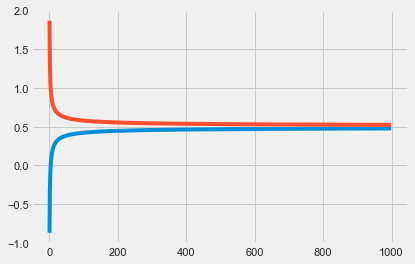

In [41]:
plt.plot(range(1, 1000), np.array(cis)[:, 0])
plt.plot(range(1, 1000), np.array(cis)[:, 1])

The useful part of the Wilson confidence interval is the lower bound, which serves as a good *pessimistic* approximator of how actually recommendable a product is. Per our problem statement, it gets used in particular to account for extremely small-sample products:

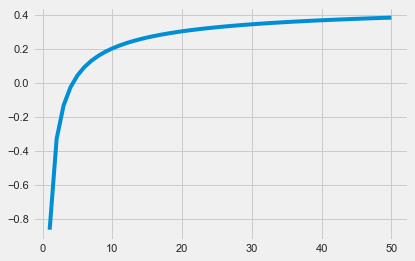

In [42]:
plt.plot(range(1, 51), np.array(cis)[:50, 0])

## Applying Wilson Confidence Interval to our data

In [43]:
# wilson_confidence_interval(pos_neg_review_scores[0], 0.95)
# beauty_recommendability_cis = np.array(
#     [wilson_confidence_interval(pos_neg_review_scores[n], 0.95) for n in range(len(pos_neg_review_scores))]
# )

beauty_recommendability_cis = np.array(
    [wilson_confidence_interval(pos_neg_review_scores[n], 0.95) for n in range(len(pos_neg_review_scores))]
)

In [44]:
beauty_recommendability_cis

array([[-0.28917459,  2.28917459],
       [ 0.46318803,  1.06622373],
       [ 0.59993847,  1.10006153],
       ...,
       [ 0.39861289,  1.60138711],
       [-2.31745475,  2.31745475],
       [-0.05164589,  0.85164589]])

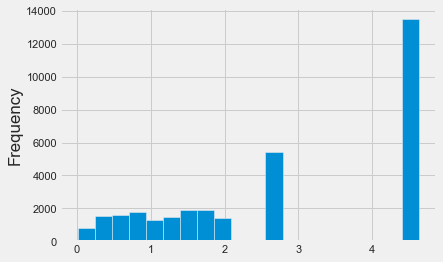

In [45]:
pd.Series(beauty_recommendability_cis[:, 1] - beauty_recommendability_cis[:, 0]).plot.hist(bins=20)